<a href="https://colab.research.google.com/github/ktanguy/staffwork/blob/main/staff_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets torch scikit-learn pandas matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [2]:
import random

# Sample data for each category
data = {
    'Assignment Issues': [
        "I can't submit my assignment on Canvas. The deadline is tomorrow.",
        "My assignment file is too large to upload to the portal.",
        "I submitted the wrong file for my assignment. Can I resubmit?",
        "The assignment submission link is not working on Canvas.",
        "I'm having trouble accessing the assignment rubric.",
        "My group partner hasn't contributed to our assignment.",
        "I need an extension for my assignment due to illness.",
        "The assignment instructions are unclear to me.",
        "I can't find the assignment submission button.",
        "My computer crashed and I lost my assignment work.",
        "I submitted my assignment late, can I still get credit?",
        "The file format required for the assignment won't upload.",
        "I accidentally deleted my assignment draft.",
        "My assignment wasn't saved properly on Canvas.",
        "I need help understanding the assignment requirements.",
        "Can I submit my assignment in a different format?",
        "My partner dropped the course, what do I do about group assignment?",
        "I submitted to the wrong assignment link by mistake.",
        "The assignment deadline passed while I was uploading.",
        "I don't have access to the software needed for this assignment.",
        "Canvas keeps logging me out when I try to submit.",
        "My assignment shows as submitted but the file is empty.",
        "I need clarification on the citation format for my paper.",
        "The assignment upload failed multiple times.",
        "Can I resubmit my assignment with corrections?",
        "My internet disconnected during assignment submission.",
        "I submitted the right file but it's showing the wrong one.",
        "The assignment page says access denied.",
        "I can't see the assignment feedback from my professor.",
        "My assignment was flagged for plagiarism but it's my own work.",
        "I need help with the assignment formatting requirements.",
        "The assignment template link is broken.",
        "My submission confirmation email never arrived.",
        "I accidentally submitted an incomplete assignment.",
        "The assignment portal closed early before the deadline.",
        "I need to update my submitted assignment with new information.",
        "My assignment file became corrupted after upload.",
        "I can't access my graded assignment to see feedback.",
        "The assignment requires tools I don't have access to.",
        "My assignment partner is not responding to messages.",
        "I submitted my assignment to the discussion board by mistake.",
        "The assignment instructions conflict with the rubric.",
        "I need guidance on which assignment format to use.",
        "My assignment submission is stuck at 99% upload.",
        "I received no confirmation after submitting my assignment.",
        "The assignment link redirects to the wrong page.",
        "I need an exception to submit my assignment late.",
        "My assignment was rejected due to file type.",
        "I can't download the assignment resources provided.",
        "The assignment grade doesn't match the rubric scoring.",
        "I need to withdraw my assignment and resubmit later.",
    ],

    'Grade Appeals': [
        "I believe my exam was graded incorrectly.",
        "My final grade doesn't match my assignment scores.",
        "I disagree with the feedback on my capstone project.",
        "Can I request a regrade for my midterm exam?",
        "My participation grade seems lower than it should be.",
        "I think there's an error in my grade calculation.",
        "I want to appeal my grade for the research paper.",
        "My quiz score wasn't recorded in the gradebook.",
        "The rubric doesn't match the grade I received.",
        "I completed extra credit but it's not reflected in my grade.",
        "My assignment was marked late but I submitted on time.",
        "Can I see my graded exam to understand what I got wrong?",
        "My group project grade is unfair compared to our work.",
        "I want to discuss my final course grade with the professor.",
        "My attendance was marked absent but I was present.",
        "The grade distribution doesn't seem fair for this course.",
        "I believe my presentation was scored too harshly.",
        "My essay deserves a higher grade based on the rubric.",
        "Can I appeal the grade for my practical examination?",
        "My lab report grade is much lower than expected.",
        "The professor said I got an A but the grade shows B.",
        "My exam score was entered incorrectly in the system.",
        "I want to challenge the grading criteria used.",
        "My grade dropped unexpectedly without explanation.",
        "I believe there's bias in how my work was graded.",
        "My resubmission wasn't considered for the final grade.",
        "The grade for my presentation doesn't reflect my performance.",
        "I need clarification on why points were deducted.",
        "My grade is lower than the average despite good work.",
        "I want a second opinion on my graded assignment.",
        "The grading seems inconsistent across students.",
        "My final exam grade contradicts my semester performance.",
        "I received a failing grade but met all requirements.",
        "My grade appeal from last month wasn't addressed.",
        "The feedback doesn't justify the low grade given.",
        "I want to meet with the dean about my grade.",
        "My GPA calculation appears to have an error.",
        "I believe my grade was affected by technical issues.",
        "My coursework grade is missing from the transcript.",
        "I want to contest the curve applied to my grade.",
        "The grading rubric was changed after I submitted.",
        "My grade doesn't reflect the effort I put in.",
        "I need documentation of my grade for scholarship purposes.",
        "My instructor graded me lower than they indicated.",
        "I want to formally appeal my semester grade.",
        "My grade was based on incomplete information.",
        "The professor's grading comments contradict the score.",
        "I believe my grade violates the academic policy.",
        "My improvement over the semester isn't reflected in the grade.",
        "I want a detailed breakdown of how my grade was calculated.",
    ],

    'Capstone': [
        "I need help selecting a capstone project topic.",
        "Can I change my capstone supervisor?",
        "I'm struggling to find data for my capstone research.",
        "When is the capstone proposal deadline?",
        "My capstone supervisor is not responding to my emails.",
        "I need approval for my capstone methodology.",
        "Can I work on a capstone project with a partner?",
        "I need access to research tools for my capstone.",
        "My capstone literature review needs feedback.",
        "I want to present my capstone progress to get guidance.",
        "Can I extend my capstone submission deadline?",
        "I need help with statistical analysis for my capstone.",
        "My capstone project scope is too broad, need advice.",
        "I want to switch my capstone topic to something else.",
        "I need ethical approval for my capstone research.",
        "My capstone supervisor suggested major revisions.",
        "I'm having trouble finding a capstone supervisor.",
        "Can I use company data for my capstone project?",
        "I need feedback on my capstone draft before final submission.",
        "My capstone defense is scheduled but I'm not ready.",
        "I want to conduct interviews for my capstone research.",
        "My capstone proposal was rejected, what should I do?",
        "I need access to the library database for capstone research.",
        "Can I change my capstone topic at this stage?",
        "I need help formatting my capstone references.",
        "My capstone supervisor is on sabbatical, who can help?",
        "I want to include a survey in my capstone methodology.",
        "The capstone guidelines are unclear to me.",
        "I need institutional approval for my capstone study.",
        "Can I submit my capstone in chapters instead of complete?",
        "I'm facing challenges with my capstone data collection.",
        "I need software training for my capstone analysis.",
        "My capstone requires IRB approval, how do I apply?",
        "I want to publish my capstone findings in a journal.",
        "I need an extension for my capstone proposal submission.",
        "My capstone methodology needs validation from experts.",
        "I'm struggling with the theoretical framework for my capstone.",
        "Can I collaborate with external organizations for my capstone?",
        "I need guidance on capstone citation style requirements.",
        "My capstone supervisor wants changes I disagree with.",
        "I want to present my capstone at a conference.",
        "I need help interpreting my capstone research results.",
        "My capstone topic overlaps with another student's work.",
        "I need access to specialized equipment for my capstone.",
        "Can I use my internship project as my capstone?",
        "I'm having trouble structuring my capstone chapters.",
        "I need a second reader for my capstone committee.",
        "My capstone defense date conflicts with another commitment.",
        "I want feedback on my capstone abstract before submission.",
        "I need help with the implications section of my capstone.",
    ],

    'Administrative': [
        "I need to update my personal information in the system.",
        "How do I request an official transcript?",
        "I want to add/drop a course after the deadline.",
        "I need a letter of recommendation from the university.",
        "How do I apply for a leave of absence?",
        "I need to update my emergency contact information.",
        "Can I get a refund for the course I dropped?",
        "I need a student verification letter for my visa.",
        "How do I change my major or program?",
        "I want to register for an overload of credits.",
        "I need help with financial aid documentation.",
        "How do I request a deferral for next semester?",
        "I need to update my payment plan.",
        "Can I get a replacement student ID card?",
        "I want to file a petition for academic exception.",
        "How do I withdraw from the university?",
        "I need documentation for my scholarship application.",
        "Can I audit a course instead of taking it for credit?",
        "I need help understanding the tuition payment deadline.",
        "How do I access my tax documents for education credits?",
        "I want to appeal my financial aid decision.",
        "I need to change my enrollment status from full-time to part-time.",
        "How do I apply for graduation?",
        "I need certification of enrollment for my employer.",
        "Can I transfer credits from another institution?",
        "I need to correct an error on my transcript.",
        "How do I request academic accommodation for disability?",
        "I want to register for courses but the system is locked.",
        "I need to pay my tuition but the portal isn't working.",
        "Can I defer my admission to next academic year?",
        "I need a letter confirming my degree completion.",
        "How do I update my address in the student portal?",
        "I want to declare a minor in addition to my major.",
        "I need information about health insurance requirements.",
        "Can I get a waiver for the student activity fee?",
        "I need to submit immunization records, where do I send them?",
        "How do I petition for course substitution?",
        "I want to enroll in independent study credits.",
        "I need clearance from all departments before graduation.",
        "Can I register for classes if I have an outstanding balance?",
        "I need to update my preferred name in university records.",
        "How do I apply for readmission after withdrawal?",
        "I want to request a grade replacement for a retaken course.",
        "I need verification of my degree for employment purposes.",
        "Can I get a copy of my diploma sent to another address?",
        "I need to complete exit counseling for my student loans.",
        "How do I access my student account statement?",
        "I want to establish a payment plan for my tuition.",
        "I need proof of enrollment for my insurance company.",
        "Can I change my course from credit to pass/fail?",
    ],

    'General Inquiry': [
        "What are the library opening hours?",
        "Where is the student lounge located?",
        "How do I join student clubs and organizations?",
        "What dining options are available on campus?",
        "Is there a gym facility for students?",
        "How do I report a maintenance issue in my dorm?",
        "What mental health services are available?",
        "How do I book a study room in the library?",
        "Are there tutoring services available?",
        "What career counseling services does ALU offer?",
        "How do I access WiFi on campus?",
        "What events are happening this week?",
        "Is there parking available for students?",
        "How do I get involved in research opportunities?",
        "What internship support does the university provide?",
        "Are there language learning resources available?",
        "How do I contact the IT helpdesk?",
        "What shuttle services are available?",
        "Is there a lost and found office?",
        "How do I reserve a conference room for my group?",
        "Where can I print documents on campus?",
        "What are the campus safety and security services?",
        "How do I get a campus tour for visiting family?",
        "Are there student discounts for local businesses?",
        "What recreational activities are available on campus?",
        "How do I sign up for campus newsletter?",
        "Where is the student health center located?",
        "What volunteer opportunities are available?",
        "How do I access career fairs and networking events?",
        "Are there religious services on campus?",
        "What support is available for international students?",
        "How do I report a conduct violation?",
        "Where can I buy university merchandise?",
        "What peer mentoring programs exist?",
        "How do I get involved in student government?",
        "Are there writing center services available?",
        "What academic workshops are offered this semester?",
        "How do I access alumni network resources?",
        "Where can I find information about study abroad programs?",
        "What technology resources are available for students?",
        "How do I submit feedback about campus services?",
        "Are there entrepreneurship resources on campus?",
        "What diversity and inclusion programs exist?",
        "How do I access disability services?",
        "Where can I find information about campus housing?",
        "What leadership development programs are available?",
        "How do I get involved in community service projects?",
        "Are there financial literacy workshops?",
        "What public speaking and presentation resources exist?",
        "How do I access the university calendar of events?",
    ]
}

# Generate dataset with variations
dataset = []
for category, examples in data.items():
    for example in examples:
        dataset.append({'text': example, 'category': category})

# Convert to DataFrame
df = pd.DataFrame(dataset)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nTotal samples: {len(df)}")
print(f"\nDistribution across categories:")
print(df['category'].value_counts().sort_index())


Total samples: 251

Distribution across categories:
category
Administrative       50
Assignment Issues    51
Capstone             50
General Inquiry      50
Grade Appeals        50
Name: count, dtype: int64


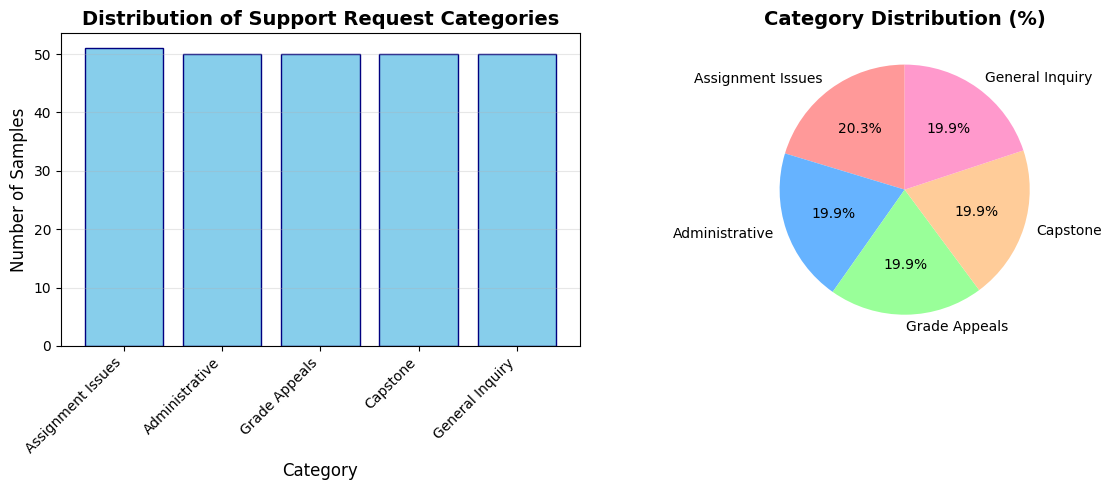

✓ Data distribution visualization saved as 'data_distribution.png'


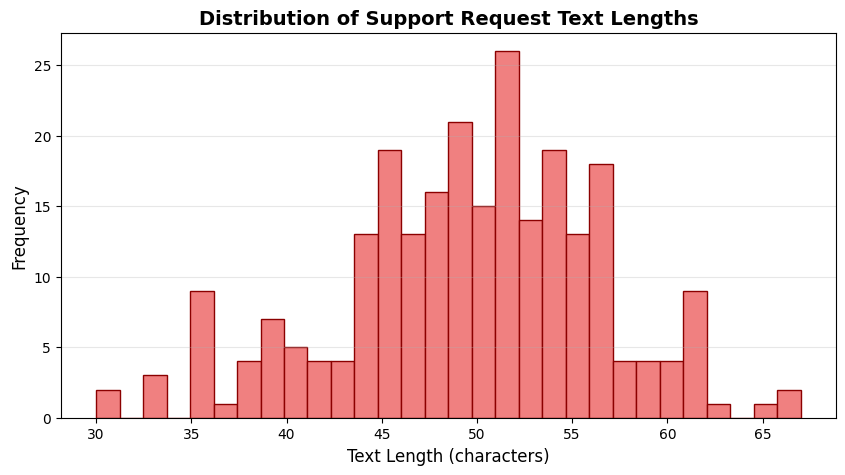

✓ Text length distribution saved as 'text_length_distribution.png'

Text length statistics:
count    251.000000
mean      49.601594
std        6.831152
min       30.000000
25%       46.000000
50%       50.000000
75%       54.000000
max       67.000000
Name: text_length, dtype: float64


In [3]:
# Category distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
category_counts = df['category'].value_counts()
plt.bar(category_counts.index, category_counts.values, color='skyblue', edgecolor='navy')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Distribution of Support Request Categories', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
        startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#ff99cc'])
plt.title('Category Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Data distribution visualization saved as 'data_distribution.png'")

# Text length distribution
df['text_length'] = df['text'].str.len()
plt.figure(figsize=(10, 5))
plt.hist(df['text_length'], bins=30, color='lightcoral', edgecolor='darkred')
plt.xlabel('Text Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Support Request Text Lengths', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.savefig('text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Text length distribution saved as 'text_length_distribution.png'")

print(f"\nText length statistics:")
print(df['text_length'].describe())

In [4]:
# Create label mapping
label2id = {label: idx for idx, label in enumerate(sorted(df['category'].unique()))}
id2label = {idx: label for label, idx in label2id.items()}

print(f"\nLabel mapping:")
for label, idx in label2id.items():
    print(f"  {idx}: {label}")

# Add numeric labels
df['label'] = df['category'].map(label2id)

# Train-test split (80-20)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"\nTrain set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")

# Initialize tokenizer
print("\nLoading DistilBERT tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize data
print("Tokenizing data...")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Create datasets
class SupportDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SupportDataset(train_encodings, train_labels)
val_dataset = SupportDataset(val_encodings, val_labels)

print("✓ Data preprocessing complete")


Label mapping:
  0: Administrative
  1: Assignment Issues
  2: Capstone
  3: General Inquiry
  4: Grade Appeals

Train set size: 200
Validation set size: 51

Loading DistilBERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing data...
✓ Data preprocessing complete


In [5]:
# Load DistilBERT model
print("\nLoading DistilBERT model...")
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train model
print("\nStarting training...")
print("This will take approximately 2-4 hours on Google Colab's free GPU")
print("-" * 80)

trainer.train()

print("\n✓ Training complete!")


Loading DistilBERT model...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.



Starting training...
This will take approximately 2-4 hours on Google Colab's free GPU
--------------------------------------------------------------------------------


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.613001,1.587471,0.235294,0.132832,0.255702,0.235294
2,1.579233,1.501321,0.607843,0.597852,0.812885,0.607843
3,1.516818,1.218994,0.901961,0.896953,0.921102,0.901961


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].



✓ Training complete!



Evaluating model on validation set...



PERFORMANCE METRICS
LOSS.......................... 1.2190
ACCURACY...................... 0.9020
F1............................ 0.8970
PRECISION..................... 0.9211
RECALL........................ 0.9020
RUNTIME....................... 5.9675
SAMPLES_PER_SECOND............ 8.5460
STEPS_PER_SECOND.............. 0.6700

DETAILED CLASSIFICATION REPORT
                   precision    recall  f1-score   support

   Administrative     1.0000    0.6000    0.7500        10
Assignment Issues     0.7857    1.0000    0.8800        11
         Capstone     1.0000    1.0000    1.0000        10
  General Inquiry     1.0000    0.9000    0.9474        10
    Grade Appeals     0.8333    1.0000    0.9091        10

         accuracy                         0.9020        51
        macro avg     0.9238    0.9000    0.8973        51
     weighted avg     0.9211    0.9020    0.8970        51



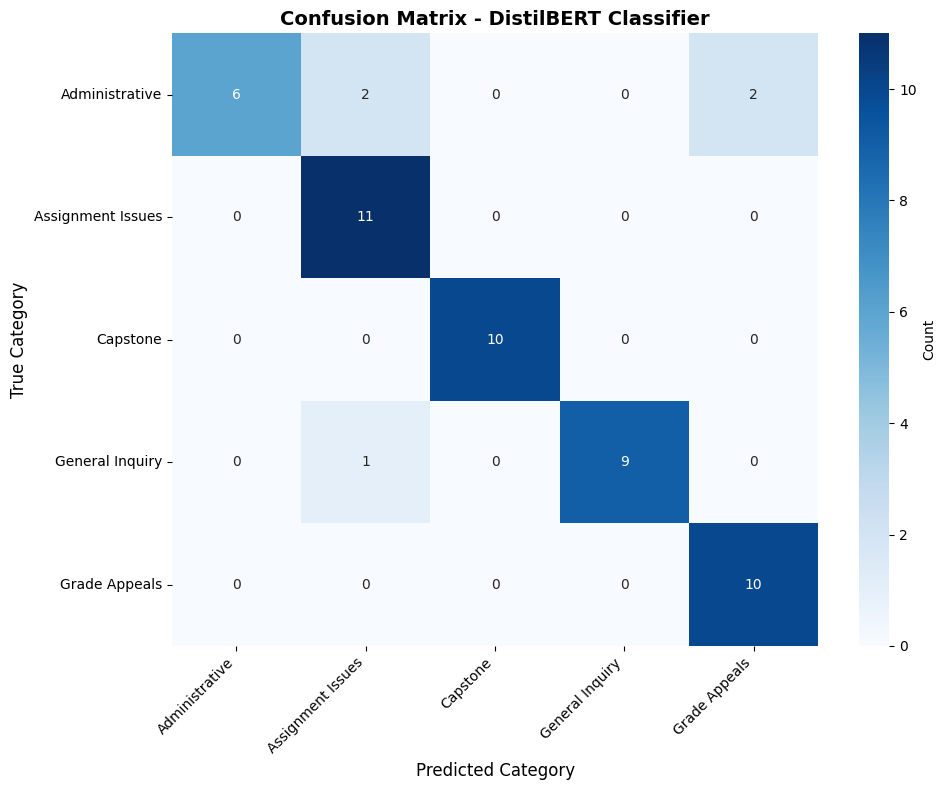

✓ Confusion matrix saved as 'confusion_matrix.png'

PER-CATEGORY ACCURACY
Administrative.......................... 60.00%
Assignment Issues....................... 100.00%
Capstone................................ 100.00%
General Inquiry......................... 90.00%
Grade Appeals........................... 100.00%


In [6]:
# Evaluate on validation set
print("\nEvaluating model on validation set...")
eval_results = trainer.evaluate()

print("\n" + "="*50)
print("PERFORMANCE METRICS")
print("="*50)
for key, value in eval_results.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '').upper()
        print(f"{metric_name:.<30} {value:.4f}")
print("="*50)

# Get predictions
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.argmax(-1)

# Detailed classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(val_labels, preds, target_names=list(label2id.keys()), digits=4))

# Confusion Matrix
cm = confusion_matrix(val_labels, preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label2id.keys()),
            yticklabels=list(label2id.keys()),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.title('Confusion Matrix - DistilBERT Classifier', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix.png'")

# Per-category accuracy
print("\n" + "="*50)
print("PER-CATEGORY ACCURACY")
print("="*50)
for idx, category in id2label.items():
    mask = np.array(val_labels) == idx
    if mask.sum() > 0:
        category_acc = accuracy_score(np.array(val_labels)[mask], preds[mask])
        print(f"{category:.<40} {category_acc*100:.2f}%")
print("="*50)

In [7]:
# Test on new examples
test_examples = [
    "I can't submit my assignment on Canvas. The deadline is tomorrow.",
    "I believe my exam was graded incorrectly and want to appeal.",
    "I need help selecting a capstone project topic.",
    "How do I request an official transcript?",
    "What are the library opening hours?",
]

print("\nTesting model on new examples:")
print("-" * 80)

for i, text in enumerate(test_examples, 1):
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Get prediction and confidence
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    confidence = probabilities[0][predicted_class].item()

    print(f"\nExample {i}:")
    print(f"Text: \"{text}\"")
    print(f"Predicted Category: {id2label[predicted_class]}")
    print(f"Confidence: {confidence*100:.2f}%")

    # Show top 3 predictions
    top3_probs, top3_indices = torch.topk(probabilities[0], 3)
    print(f"Top 3 predictions:")
    for prob, idx in zip(top3_probs, top3_indices):
        print(f"  - {id2label[idx.item()]}: {prob.item()*100:.2f}%")
    print("-" * 80)


Testing model on new examples:
--------------------------------------------------------------------------------

Example 1:
Text: "I can't submit my assignment on Canvas. The deadline is tomorrow."
Predicted Category: Assignment Issues
Confidence: 34.88%
Top 3 predictions:
  - Assignment Issues: 34.88%
  - Capstone: 18.76%
  - Grade Appeals: 17.95%
--------------------------------------------------------------------------------

Example 2:
Text: "I believe my exam was graded incorrectly and want to appeal."
Predicted Category: Grade Appeals
Confidence: 31.98%
Top 3 predictions:
  - Grade Appeals: 31.98%
  - Administrative: 21.17%
  - Assignment Issues: 16.73%
--------------------------------------------------------------------------------

Example 3:
Text: "I need help selecting a capstone project topic."
Predicted Category: Capstone
Confidence: 33.06%
Top 3 predictions:
  - Capstone: 33.06%
  - Administrative: 18.56%
  - Grade Appeals: 17.85%
-----------------------------------------

In [8]:
print("\n" + "="*80)
print("SECTION 8: SAVE MODEL")
print("="*80)

# Save model and tokenizer
model_save_path = './distilbert_support_classifier'
print(f"\nSaving model to: {model_save_path}")

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print("✓ Model and tokenizer saved successfully!")

# Get model size
import os
model_size = sum(os.path.getsize(os.path.join(dirpath,filename))
                 for dirpath, dirnames, filenames in os.walk(model_save_path)
                 for filename in filenames)
print(f"Model size: {model_size / (1024*1024):.2f} MB")


SECTION 8: SAVE MODEL

Saving model to: ./distilbert_support_classifier


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Model and tokenizer saved successfully!
Model size: 256.11 MB


In [9]:
CONFIDENCE_THRESHOLD = 0.70

print(f"\nConfidence threshold for auto-assignment: {CONFIDENCE_THRESHOLD*100}%")
print("-" * 80)

routing_results = {'auto_assigned': 0, 'flagged_for_review': 0}

for i, text in enumerate(test_examples, 1):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    confidence = probabilities[0][predicted_class].item()

    print(f"\nTicket {i}: \"{text[:50]}...\"")
    print(f"Predicted: {id2label[predicted_class]} (Confidence: {confidence*100:.2f}%)")

    if confidence >= CONFIDENCE_THRESHOLD:
        print(f"✓ Action: AUTO-ASSIGN to {id2label[predicted_class]} department")
        routing_results['auto_assigned'] += 1
    else:
        print(f"⚠ Action: FLAG FOR MANUAL REVIEW (low confidence)")
        routing_results['flagged_for_review'] += 1
    print("-" * 80)

print(f"\nRouting Summary:")
print(f"Auto-assigned: {routing_results['auto_assigned']}/{len(test_examples)}")
print(f"Flagged for review: {routing_results['flagged_for_review']}/{len(test_examples)}")


Confidence threshold for auto-assignment: 70.0%
--------------------------------------------------------------------------------

Ticket 1: "I can't submit my assignment on Canvas. The deadli..."
Predicted: Assignment Issues (Confidence: 34.88%)
⚠ Action: FLAG FOR MANUAL REVIEW (low confidence)
--------------------------------------------------------------------------------

Ticket 2: "I believe my exam was graded incorrectly and want ..."
Predicted: Grade Appeals (Confidence: 31.98%)
⚠ Action: FLAG FOR MANUAL REVIEW (low confidence)
--------------------------------------------------------------------------------

Ticket 3: "I need help selecting a capstone project topic...."
Predicted: Capstone (Confidence: 33.06%)
⚠ Action: FLAG FOR MANUAL REVIEW (low confidence)
--------------------------------------------------------------------------------

Ticket 4: "How do I request an official transcript?..."
Predicted: Administrative (Confidence: 25.52%)
⚠ Action: FLAG FOR MANUAL REVIEW (low 

In [11]:
# Install required packages
!pip install flask flask-cors flask-restx pyngrok -q

from flask import Flask, request
from flask_restx import Api, Resource, fields
from flask_cors import CORS
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import threading
from pyngrok import ngrok
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.7 MB/s eta 0:00:00


In [12]:
CONFIDENCE_THRESHOLD = 0.70

In [14]:
app = Flask(__name__)
CORS(app)

# Swagger/OpenAPI configuration
api = Api(
    app,
    version='1.0',
    title='Academic Support Ticket Classifier API',
    description='AI-powered ticket classification using DistilBERT',
    doc='/docs'
)

# Create namespace
ns = api.namespace('api', description='Ticket Classification Operations')

In [15]:
# Input model
ticket_input = api.model('TicketInput', {
    'text': fields.String(
        required=True,
        description='The support ticket description',
        example='I cant submit my assignment on Canvas. The deadline is tomorrow.'
    )
})

# Output model
classification_result = api.model('ClassificationResult', {
    'predicted_category': fields.String(description='Predicted category'),
    'confidence': fields.Float(description='Confidence score (0-1)'),
    'confidence_percentage': fields.String(description='Confidence as percentage'),
    'routing_action': fields.String(description='auto_assign or flag_for_review'),
    'assigned_to': fields.String(description='Department or review queue'),
    'inference_time_ms': fields.String(description='Inference time in milliseconds'),
})

response_model = api.model('Response', {
    'success': fields.Boolean(description='Request success status'),
    'data': fields.Nested(classification_result),
    'input_text': fields.String(description='Original input text')
})

In [16]:
def classify_ticket_api(text):
    """Classify a support ticket"""
    start_time = time.time()

    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    predicted_class = torch.argmax(probabilities, dim=-1).item()
    confidence = probabilities[0][predicted_class].item()

    # Top 3 predictions
    top3_probs, top3_indices = torch.topk(probabilities[0], 3)
    top3_predictions = [
        {
            "category": id2label[idx.item()],
            "confidence": float(prob.item())
        }
        for prob, idx in zip(top3_probs, top3_indices)
    ]

    # Routing decision
    category_to_dept = {
        "Administrative": "Registrar's Office",
        "Assignment Issues": "Academic Support",
        "Capstone": "Capstone Office",
        "General Inquiry": "Student Services",
        "Grade Appeals": "Academic Affairs"
    }

    if confidence >= CONFIDENCE_THRESHOLD:
        routing_action = "auto_assign"
        assigned_to = category_to_dept[id2label[predicted_class]]
    else:
        routing_action = "flag_for_review"
        assigned_to = "Manual Review Queue"

    inference_time = (time.time() - start_time) * 1000

    return {
        "predicted_category": id2label[predicted_class],
        "confidence": float(confidence),
        "confidence_percentage": f"{confidence * 100:.2f}%",
        "routing_action": routing_action,
        "assigned_to": assigned_to,
        "top_3_predictions": top3_predictions,
        "inference_time_ms": f"{inference_time:.2f}"
    }

In [17]:
@ns.route('/health')
class HealthCheck(Resource):
    """Health check endpoint"""

    def get(self):
        """Check API health status"""
        return {
            "status": "healthy",
            "model": "DistilBERT",
            "categories": list(id2label.values()),
            "confidence_threshold": CONFIDENCE_THRESHOLD
        }

@ns.route('/classify')
class ClassifyTicket(Resource):
    """Ticket classification endpoint"""

    @api.expect(ticket_input, validate=True)
    @api.marshal_with(response_model)
    @api.response(200, 'Success')
    @api.response(400, 'Invalid input')
    @api.response(500, 'Internal error')
    def post(self):
        """
        Classify a support ticket

        Returns the predicted category, confidence score, and routing decision.
        """
        try:
            data = request.json

            if not data or 'text' not in data:
                api.abort(400, "Missing 'text' field in request body")

            text = data['text'].strip()

            if not text:
                api.abort(400, "Text field cannot be empty")

            # Classify
            result = classify_ticket_api(text)

            return {
                "success": True,
                "data": result,
                "input_text": text
            }

        except Exception as e:
            api.abort(500, str(e))

@ns.route('/categories')
class Categories(Resource):
    """Get available categories"""

    def get(self):
        """List all available support categories"""
        return {
            "categories": list(id2label.values()),
            "total": len(id2label)
        }

@ns.route('/stats')
class Statistics(Resource):
    """Get model statistics"""

    def get(self):
        """Get model information and statistics"""
        return {
            "model_info": {
                "architecture": "DistilBERT",
                "num_categories": len(id2label),
                "categories": list(id2label.values()),
                "confidence_threshold": CONFIDENCE_THRESHOLD,
                "device": str(device)
            },
            "performance": {
                "accuracy": float(eval_results.get('eval_accuracy', 0)),
                "f1_score": float(eval_results.get('eval_f1', 0)),
                "precision": float(eval_results.get('eval_precision', 0)),
                "recall": float(eval_results.get('eval_recall', 0))
            }
        }

In [26]:
!pip install pycloudflared -q

from pycloudflared import try_cloudflare

def run_flask():
    """Run Flask app"""
    app.run(port=5000, use_reloader=False)

# Start Flask in a background thread
print("\nStarting Flask API server...")
flask_thread = threading.Thread(target=run_flask, daemon=True)
flask_thread.start()

# Wait for Flask to start
time.sleep(3)

# Start Cloudflare tunnel (no auth needed!)
print("Creating public URL with Cloudflare Tunnel...")
public_url = try_cloudflare(port=5000)

print("\n" + "="*80)
print(" FLASK API IS NOW RUNNING!")
print("="*80)
print(f"\n Public URL: {public_url}")
print(f"\n Swagger UI: {public_url}/docs")
print(f"\n API Endpoints:")
print(f"   GET  {public_url}/api/health      - Health check")
print(f"   GET  {public_url}/api/categories  - List categories")
print(f"   GET  {public_url}/api/stats       - Model statistics")
print(f"   POST {public_url}/api/classify    - Classify ticket")
print("\n" + "="*80)
print("\n Click the Swagger UI link above to test the API interactively!")
print("="*80)


Starting Flask API server...
 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


Creating public URL with Cloudflare Tunnel...
 * Running on https://den-mike-pays-determines.trycloudflare.com
 * Traffic stats available on http://127.0.0.1:20241/metrics

 FLASK API IS NOW RUNNING!

 Public URL: Urls(tunnel='https://den-mike-pays-determines.trycloudflare.com', metrics='http://127.0.0.1:20241/metrics', process=<Popen: returncode: None args: ['/usr/local/lib/python3.12/dist-packages/pyc...>)

 Swagger UI: Urls(tunnel='https://den-mike-pays-determines.trycloudflare.com', metrics='http://127.0.0.1:20241/metrics', process=<Popen: returncode: None args: ['/usr/local/lib/python3.12/dist-packages/pyc...>)/docs

 API Endpoints:
   GET  Urls(tunnel='https://den-mike-pays-determines.trycloudflare.com', metrics='http://127.0.0.1:20241/metrics', process=<Popen: returncode: None args: ['/usr/local/lib/python3.12/dist-packages/pyc...>)/api/health      - Health check
   GET  Urls(tunnel='https://den-mike-pays-determines.trycloudflare.com', metrics='http://127.0.0.1:20241/metrics', p